Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Četvrta laboratorijska vježba: Procjena parametara, probabilistički grafički modeli, grupiranje

*Verzija: 1.0
Zadnji put ažurirano: 1. listopada 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **21. siječnja 2024. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Četvrta laboratorijska vježba sastoji se od osam zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline
import warnings
warnings.filterwarnings('ignore')

def plot_silhouette(n_clusters, X):
    # Kôd preuzet s http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.cm.get_cmap("Dark2")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Vrijednosti koeficijenta siluete")
    ax1.set_ylabel("Oznaka grupe")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = plt.cm.get_cmap("Dark2")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers # changed to black
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="black", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1. Procjena maksimalne izglednosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [2]:
def L(mu, N, m):
    prob = 1.0
    return prob*(mu**m)*((1-mu)**(N-m))

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

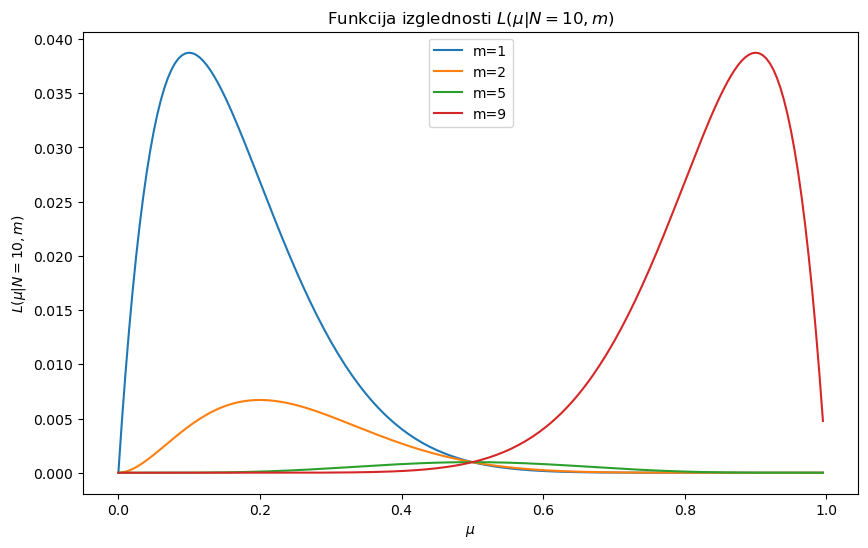

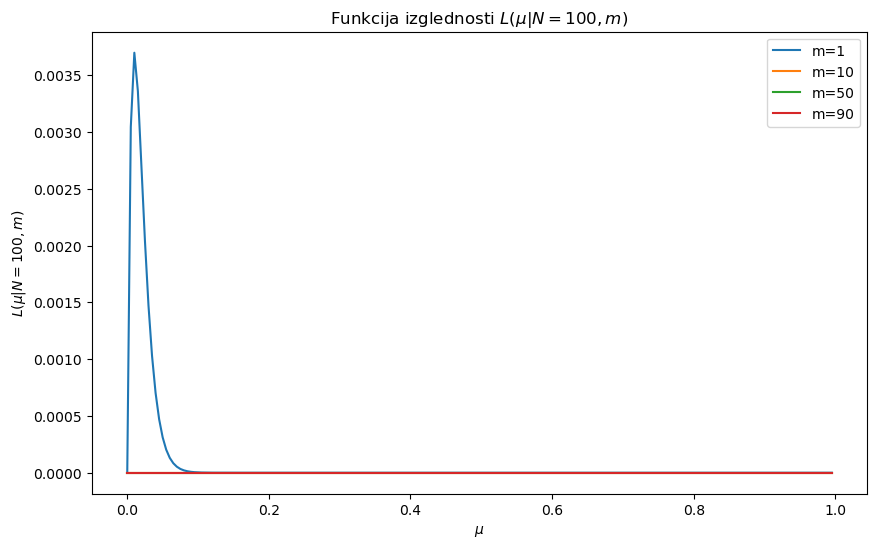

In [3]:
N1 = 10
m_values1 = [1, 2, 5, 9]
N2 = 100
m_values2 = [1, 10, 50, 90]

mu_values = arange(0, 1, 0.005)

figure(figsize=(10, 6))

for m in m_values1:
    probabilities = []
    for mu in mu_values:
        probabilities.append(L(mu, N1, m))
    plot(mu_values, probabilities, label=f'm={m}')

title('Funkcija izglednosti $L(\\mu | N=10, m)$')
xlabel('$\\mu$')
ylabel('$L(\\mu | N=10, m)$')
legend()
show()

figure(figsize=(10, 6))
for m in m_values2:
    probabilities = []
    for mu in mu_values:
        probabilities.append(L(mu, N2, m))
    plot(mu_values, probabilities, label=f'm={m}')

title('Funkcija izglednosti $L(\\mu | N=100, m)$')
xlabel('$\\mu$')
ylabel('$L(\\mu | N=100, m)$')
legend()
show()

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

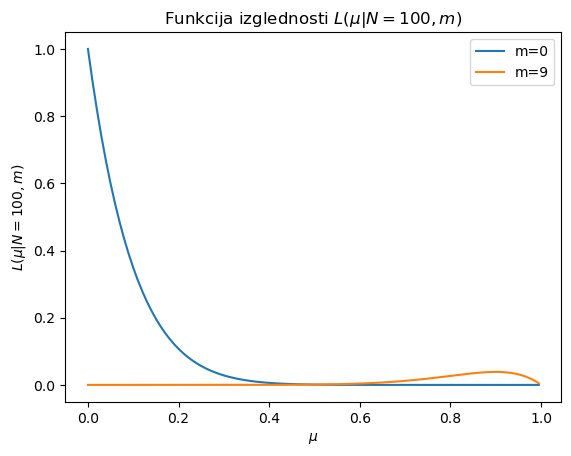

In [4]:
N = 10

probabilities = []
for mu in mu_values:
    probabilities.append(L(mu, N, 0))
plot(mu_values, probabilities, label=f'm=0')
probabilities = []
for mu in mu_values:
    probabilities.append(L(mu, N, 9))
plot(mu_values, probabilities, label=f'm=9')

title('Funkcija izglednosti $L(\\mu | N=100, m)$')
xlabel('$\\mu$')
ylabel('$L(\\mu | N=100, m)$')
legend()
show()

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

### 2. Procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

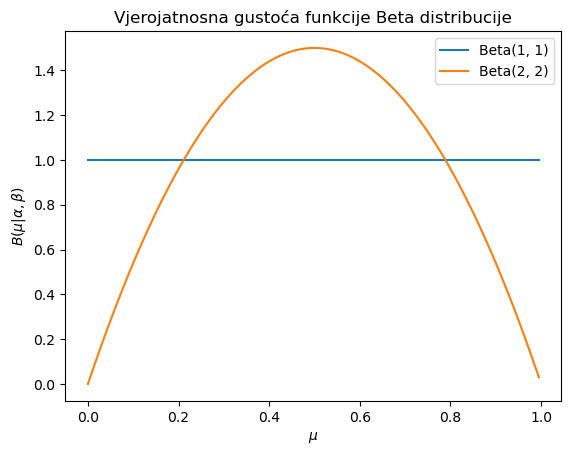

In [5]:
from scipy.stats import beta

probabilities1 = [beta.pdf(mu, 1, 1) for mu in mu_values]
probabilities2 = [beta.pdf(mu, 2, 2) for mu in mu_values]

plot(mu_values, probabilities1, label='Beta(1, 1)')
plot(mu_values, probabilities2, label='Beta(2, 2)')
title('Vjerojatnosna gustoća funkcije Beta distribucije')
xlabel('$\\mu$')
ylabel('$B(\\mu | \\alpha, \\beta)$')
legend()
show()


**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

#### (b)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

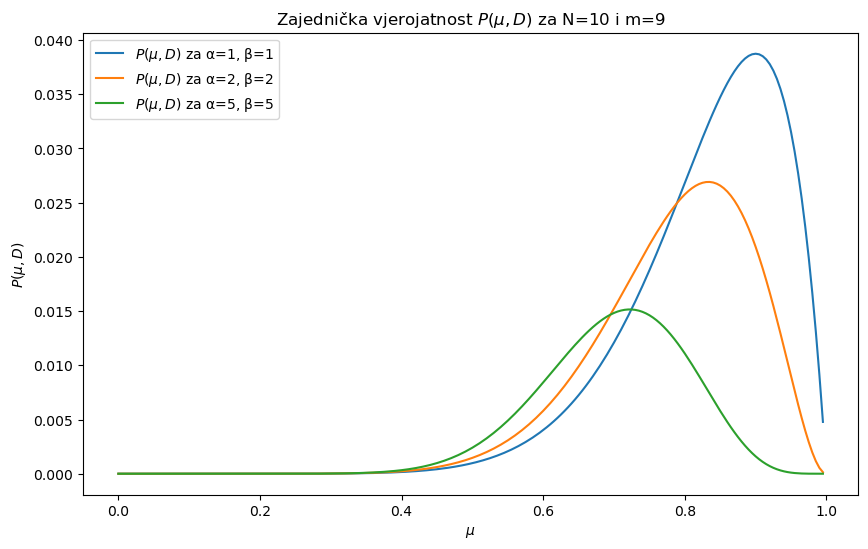

In [6]:
N = 10
m = 9

alphas = [1, 2, 5]
betas = [1, 2, 5]

figure(figsize=(10, 6))

for a, b in zip(alphas, betas):
    joint_probabilities = []
    for mu in mu_values:
        joint_probabilities.append(1.0 * L(mu, N, m) * beta.pdf(mu, a, b))
    plot(mu_values, joint_probabilities, label=f'$P(\\mu, D)$ za α={a}, β={b}')

title(f'Zajednička vjerojatnost $P(\\mu, D)$ za N={N} i m={m}')
xlabel('$\\mu$')
ylabel('$P(\\mu, D)$')
legend()
show()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

#### (c)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

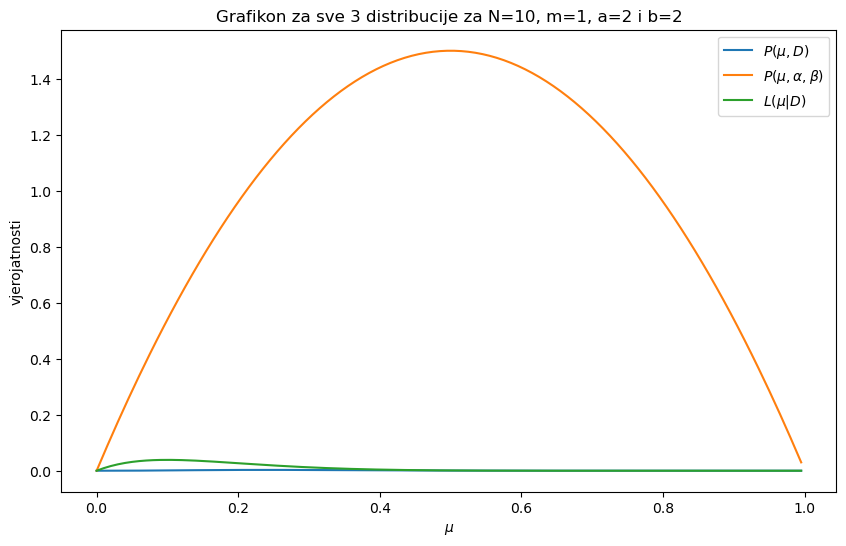

In [7]:
N = 10
m = 1
a = 2
b = 2

figure(figsize=(10, 6))

likelihood = []
betad = []
joint = []
for mu in mu_values:
    likelihood.append(L(mu, N, m))
    betad.append(beta.pdf(mu, a, b))
    joint.append(1.0 * L(mu, N, m) * beta.cdf(mu, a, b))
plot(mu_values, joint, label=f'$P(\\mu, D)$')
plot(mu_values, betad, label=f'$P(\\mu, \\alpha, \\beta)$')
plot(mu_values, likelihood, label=f'$L(\\mu | D)$')

title(f'Grafikon za sve 3 distribucije za N={N}, m={m}, a={a} i b={b}')
xlabel('$\\mu$')
ylabel('vjerojatnosti')
legend()
show()

### 3. Analiza skupa podataka *Iris*

#### (a)

Učitajte skup podataka *Iris* korištenjem funkcije [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

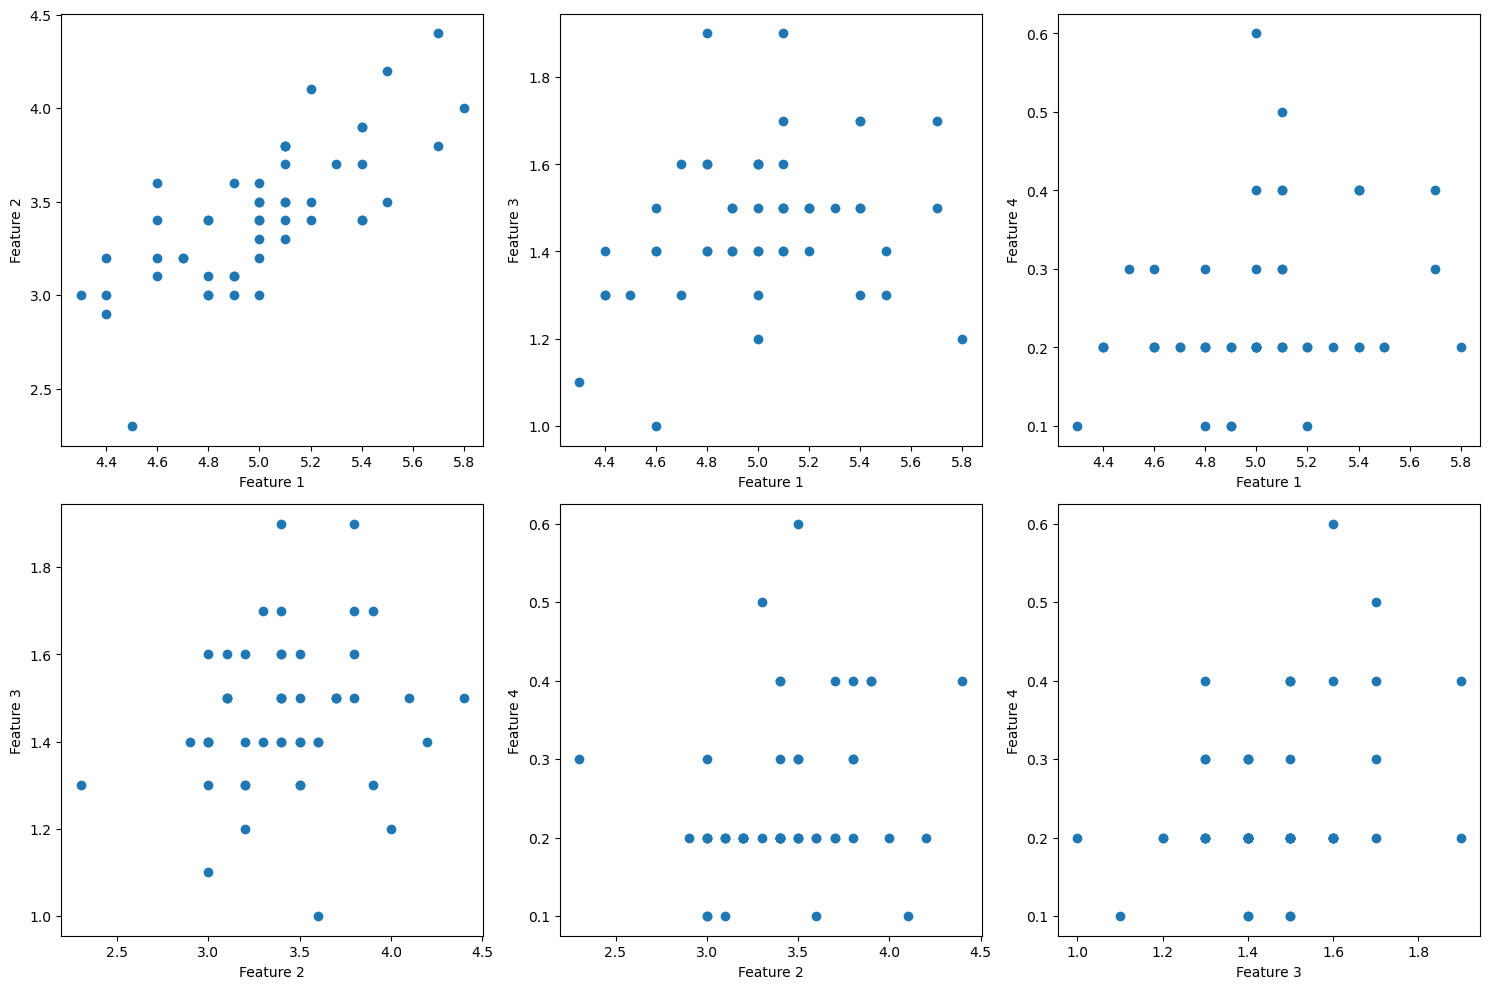

In [29]:
from sklearn.datasets import load_iris
import itertools as it

iris = load_iris()
data = iris.data
target = iris.target

chosen_class = 0
flag = (target == chosen_class)
chosen_data = data[flag]

combinations = list(it.combinations(range(data.shape[1]), 2))

figure(figsize=(15, 10))

for i, (feature1, feature2) in enumerate(combinations, 1):
    subplot(2, 3, i)
    scatter(chosen_data[:, feature1], chosen_data[:, feature2])
    xlabel(f'Feature {feature1+1}')
    ylabel(f'Feature {feature2+1}')

tight_layout()
show()


#### (b)

Pogledajte opis modula [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) te proučite funkciju [`norm`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [9]:
from scipy.stats import norm

def L_gauss(x, mi, sigma):
    log_likelihood = sum(norm.logpdf(x, loc=mi, scale=sqrt(sigma)))
    return log_likelihood


#### (c)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [10]:
for i in range(chosen_data.shape[1]):
    feature_data = chosen_data[:, i]
    mi = mean(feature_data)
    dev = var(feature_data)
    likelihood = L_gauss(feature_data, mi, dev)
    print(f'Log-izglednost značajke {i + 1}: {likelihood}')


Log-izglednost značajke 1: -18.305163312803863
Log-izglednost značajke 2: -21.939396526466606
Log-izglednost značajke 3: 17.089786091159766
Log-izglednost značajke 4: 42.06460979129481


#### (d)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [11]:
from scipy.stats import pearsonr

for i in range(chosen_data.shape[1]):
    for j in range(i + 1, chosen_data.shape[1]):
        feature1_data = chosen_data[:, i]
        feature2_data = chosen_data[:, j]
        result = pearsonr(feature1_data, feature2_data)
        print(f'Korelacija značajki {i+1} i {j+1}: {result}')


Korelacija značajki 1 i 2: PearsonRResult(statistic=0.7425466856651599, pvalue=6.709843017660432e-10)
Korelacija značajki 1 i 3: PearsonRResult(statistic=0.2671757588687572, pvalue=0.06069778380113468)
Korelacija značajki 1 i 4: PearsonRResult(statistic=0.27809835293596963, pvalue=0.05052644176398266)
Korelacija značajki 2 i 3: PearsonRResult(statistic=0.17769996678227074, pvalue=0.2169789241968609)
Korelacija značajki 2 i 4: PearsonRResult(statistic=0.23275201136287937, pvalue=0.10382114330524586)
Korelacija značajki 3 i 4: PearsonRResult(statistic=0.3316300408041187, pvalue=0.01863891500753723)


#### (e)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [12]:
cov_biased = cov(chosen_data, rowvar=False, bias=True)
cov_unbiased = cov(chosen_data, rowvar=False, bias=False)

print(f"Pristrana ML-procjena kovarijacijske matrice: \n{cov_biased}")
print(f"Nepristrana ML-procjena kovarijacijske matrice: \n{cov_unbiased}")
print()

sample_sizes = [int(chosen_data.shape[0]/4), int(chosen_data.shape[0]/2), chosen_data.shape[0]]

for sample_size in sample_sizes:
    sampled_data = chosen_data[:sample_size, :]
    
    cov_biased = cov(sampled_data, rowvar=False, bias=True)
    cov_unbiased = cov(sampled_data, rowvar=False, bias=False)
    
    apsolutna = mean(abs(cov_biased - cov_unbiased))
    kvadratna = mean((cov_biased - cov_unbiased)**2)
    
    
    print(f'{sample_size} značajki:\n\tApsolutna razlika: {apsolutna}\n\tKvadratna razlika: {kvadratna}')


Pristrana ML-procjena kovarijacijske matrice: 
[[0.121764 0.097232 0.016028 0.010124]
 [0.097232 0.140816 0.011464 0.009112]
 [0.016028 0.011464 0.029556 0.005948]
 [0.010124 0.009112 0.005948 0.010884]]
Nepristrana ML-procjena kovarijacijske matrice: 
[[0.12424898 0.09921633 0.0163551  0.01033061]
 [0.09921633 0.1436898  0.01169796 0.00929796]
 [0.0163551  0.01169796 0.03015918 0.00606939]
 [0.01033061 0.00929796 0.00606939 0.01110612]]

12 značajki:
	Apsolutna razlika: 0.0023989898989899023
	Kvadratna razlika: 1.293849160799922e-05
25 značajki:
	Apsolutna razlika: 0.0018493333333333307
	Kvadratna razlika: 7.680071499999976e-06
50 značajki:
	Apsolutna razlika: 0.0007689234693877489
	Kvadratna razlika: 1.4518483236151334e-06


### 4. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate. Upute se nalaze na gornjoj poveznici. Za korisnike Anaconde, najlakše je upisati `conda install -c ankurankan pgmpy` (ili `pip install pgmpy` ako ne prolazi) unutar Anaconda Prompta (i ponovno pokrenuti Jupyter).

Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monty%20Hall%20Problem.ipynb)).

In [13]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


In [14]:
model = BayesianNetwork([("C", "S"), ("C", "R"), ("R", "W"), ("S", "W")])

cpd_c = TabularCPD("C", 2, 
                   [[0.5], [0.5]])
cpd_s = TabularCPD('S', 2, 
                   [[0.5, 0.9], [0.5, 0.1]],
                   evidence=['C'], evidence_card=[2])

cpd_r = TabularCPD('R', 2, 
                   [[0.8, 0.2], [0.2, 0.8]],
                   evidence=['C'], evidence_card=[2])

cpd_w = TabularCPD('W', 2, 
                   [[1, 0.1, 0.1, 0.01], [0, 0.9, 0.9, 0.99]],
                   evidence=['S', 'R'], evidence_card=[2, 2])

model.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

#model.check_model()

infer = VariableElimination(model)
query1 = infer.query(variables=['W'])
query2 = infer.query(variables=['S'], evidence={'W': 1})
query3 = infer.query(variables=['R'], evidence={'W': 1})
query4 = infer.query(variables=['C'], evidence={'S': 1, 'R': 1})
query5 = infer.query(variables=['C'])
print(query1)
print(query2)
print(query3)
print(query4)
print(query5)


+------+----------+
| W    |   phi(W) |
+======+==========+
| W(0) |   0.3529 |
+------+----------+
| W(1) |   0.6471 |
+------+----------+
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.5702 |
+------+----------+
| S(1) |   0.4298 |
+------+----------+
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2921 |
+------+----------+
| R(1) |   0.7079 |
+------+----------+
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5556 |
+------+----------+
| C(1) |   0.4444 |
+------+----------+
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5000 |
+------+----------+
| C(1) |   0.5000 |
+------+----------+


**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?  
**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  
**Q:** Koja je razlika između posteriornog upita i MAP-upita?  
**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

### 5. Efekt objašnjavanja

 **Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [15]:
evidence = {'W': 1}

sprinkler_on = infer.query(variables=['R'], evidence={'W': 1, 'S': 1})
sprinkler_off = infer.query(variables=['R'], evidence={'W': 1, 'S': 0})

print(f'Vjerojatnost kiše ako prskalica radi, a trava je mokra:\n{sprinkler_on}')
print(f'Vjerojatnost kiše ako prskalica ne radi, a trava je mokra:\n{sprinkler_off}')

Vjerojatnost kiše ako prskalica radi, a trava je mokra:
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.6796 |
+------+----------+
| R(1) |   0.3204 |
+------+----------+
Vjerojatnost kiše ako prskalica ne radi, a trava je mokra:
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.0000 |
+------+----------+
| R(1) |   1.0000 |
+------+----------+


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom?

### 6. Algoritam k-sredina

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-means*), njegovim glavnim nedostatcima te pretpostavkama.

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

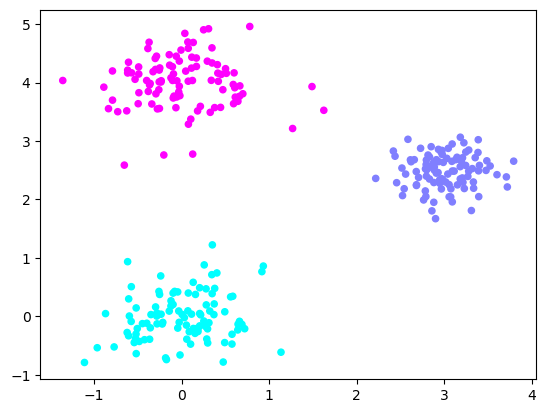

In [16]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

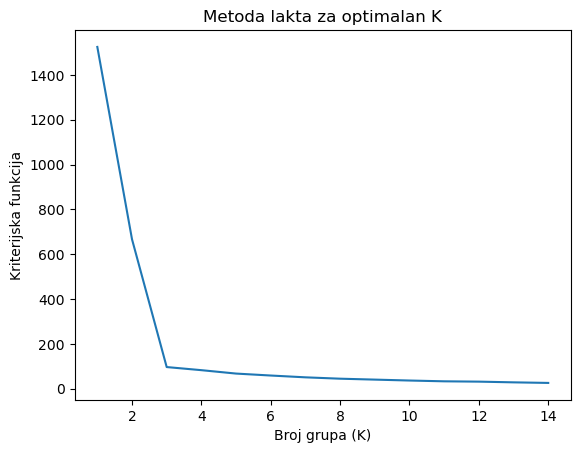

In [17]:
from sklearn.cluster import KMeans

ks = arange(1,15,1)
js = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xp)
    js.append(kmeans.inertia_)
    
kmeansp = KMeans(n_clusters=3, random_state=0).fit(Xp)
labelsp = kmeansp.labels_

plot(ks, js, linestyle='-', marker='')
title('Metoda lakta za optimalan K')
xlabel('Broj grupa (K)')
ylabel('Kriterijska funkcija')
show()

**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate?    
**Q:** Je li ova metoda robusna?  
**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

For n_clusters = 2 The average silhouette_score is : 0.59280796169837


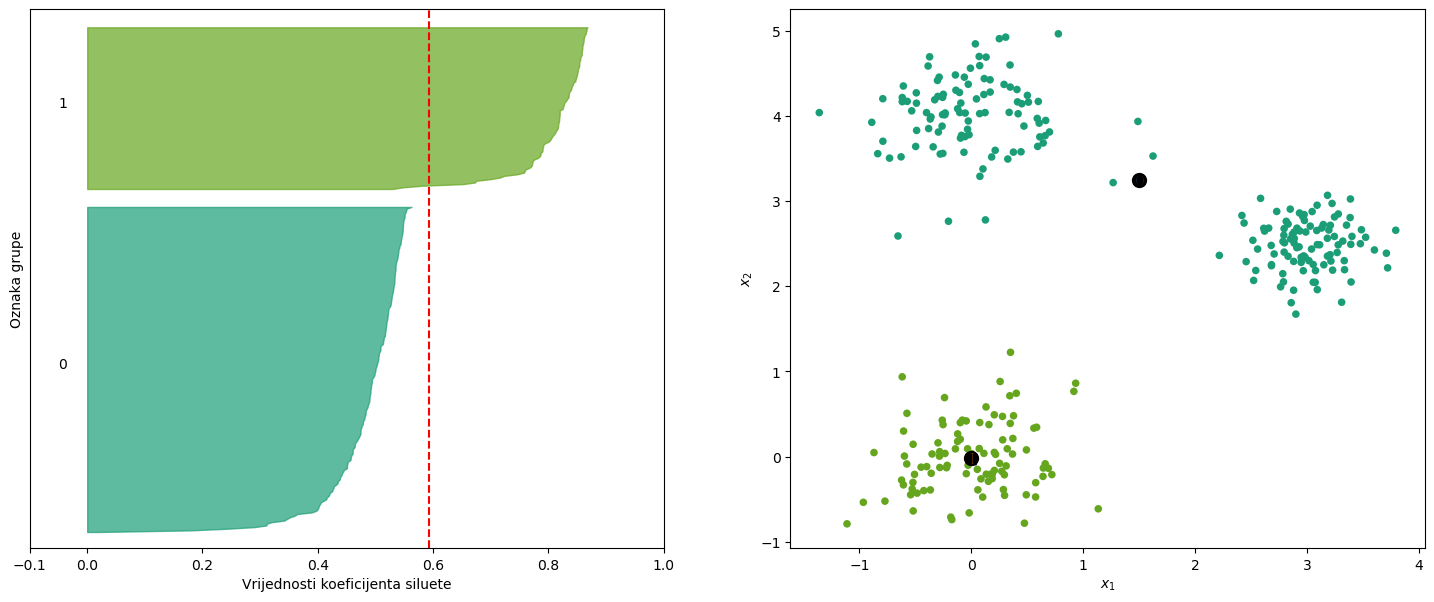

For n_clusters = 3 The average silhouette_score is : 0.7975462212061406


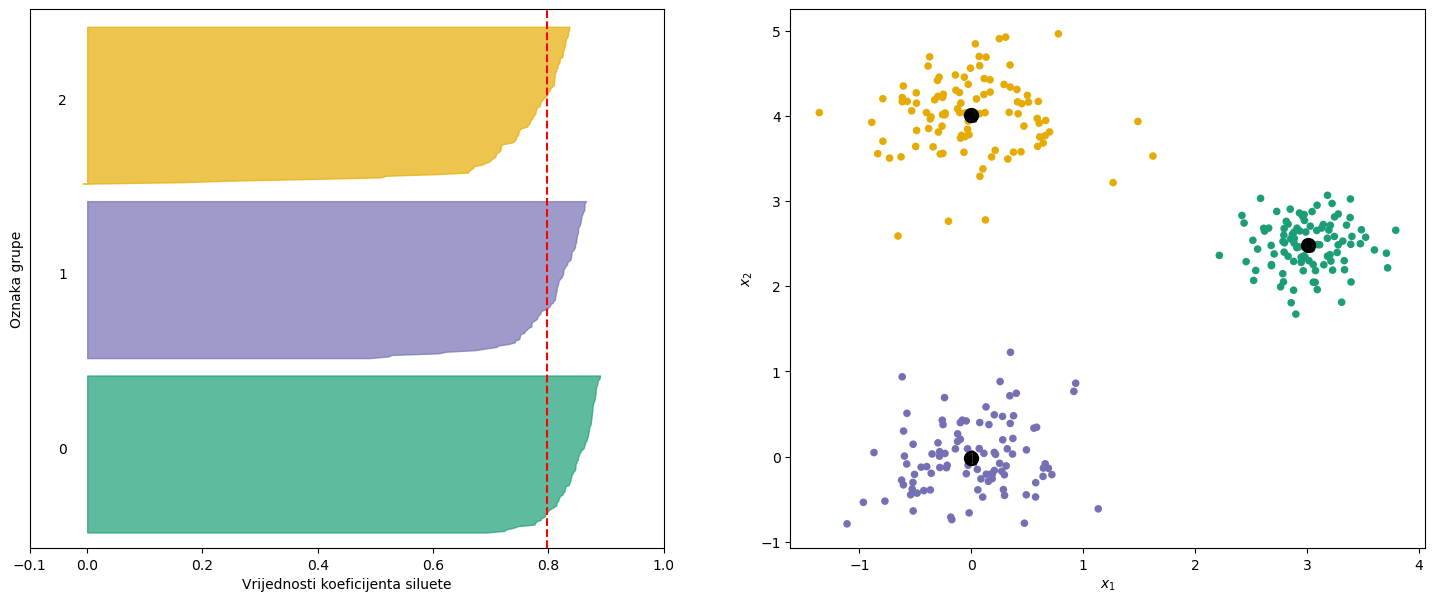

For n_clusters = 5 The average silhouette_score is : 0.5059026123508755


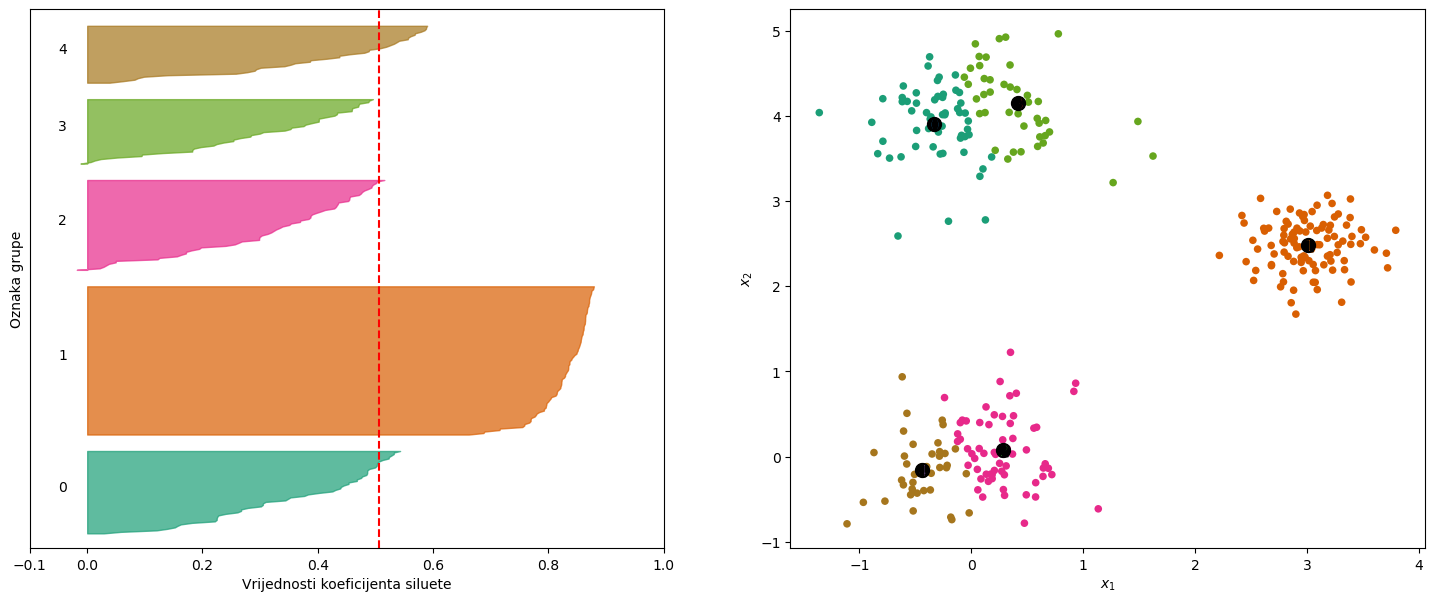

In [18]:
ks = [2, 3, 5]
for k in ks:
    plot_silhouette(k, Xp)


**Q:** Kako biste se gledajući ove slike odlučili za $K$?  
**Q:** Koji su problemi ovog pristupa?

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-sredina te što se događa ako te pretpostavke nisu zadovoljene. 

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

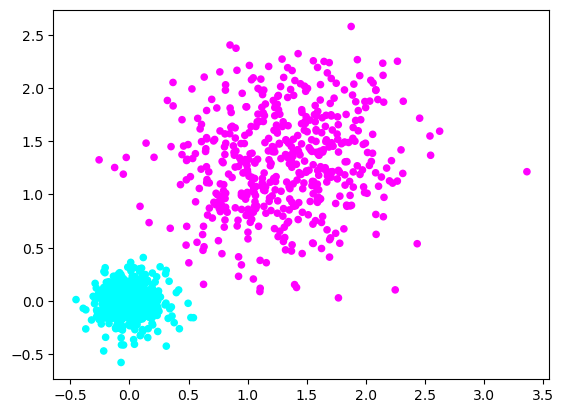

In [19]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

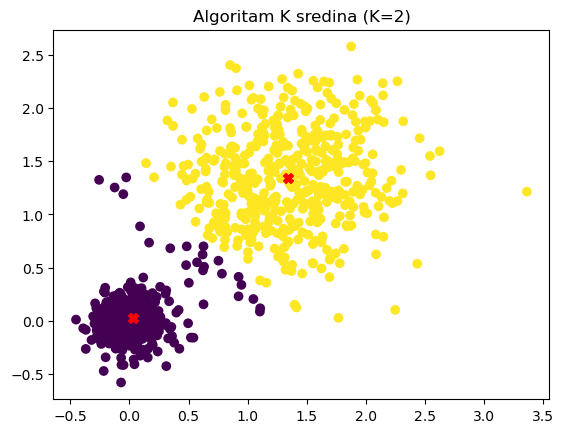

In [20]:
kmeans1 = KMeans(n_clusters=2, random_state=0).fit(X1)
labels1 = kmeans1.labels_

scatter(X1[:, 0], X1[:, 1], c=labels1)
scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=50, c='red', marker='X')
title('Algoritam K sredina (K=2)')
show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (d)

Isprobajte algoritam k-sredina na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

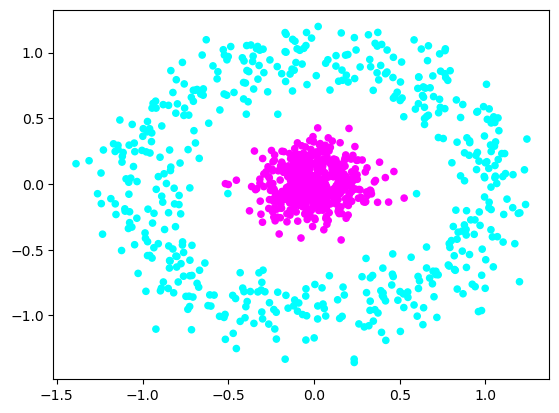

In [21]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Ponovno, naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

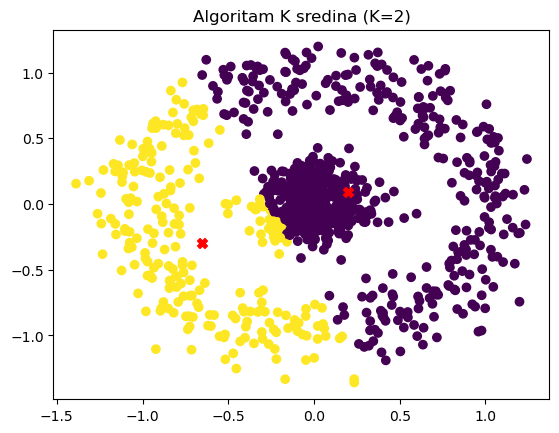

In [22]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(X2)
labels2 = kmeans2.labels_

scatter(X2[:, 0], X2[:, 1], c=labels2)
scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=50, c='red', marker='X')
title('Algoritam K sredina (K=2)')
show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

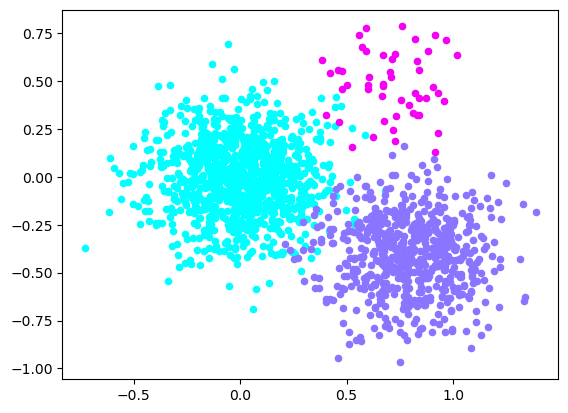

In [23]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-sredina (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

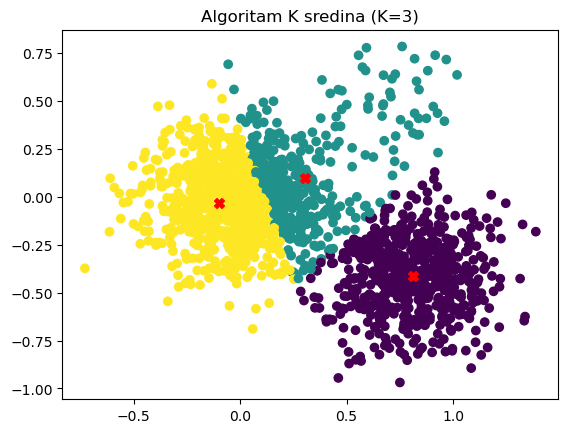

In [24]:
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(X3)
labels3 = kmeans3.labels_

scatter(X3[:, 0], X3[:, 1], c=labels3)
scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], s=50, c='red', marker='X')
title('Algoritam K sredina (K=3)')
show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

### 7. Model Gaussovih mješavina

Sada kada ste se upoznali s ograničenjima algoritma k-sredina, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-sredina (odnosno, algoritam k-sredina specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (c)-(e). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [25]:
from sklearn.mixture import GaussianMixture

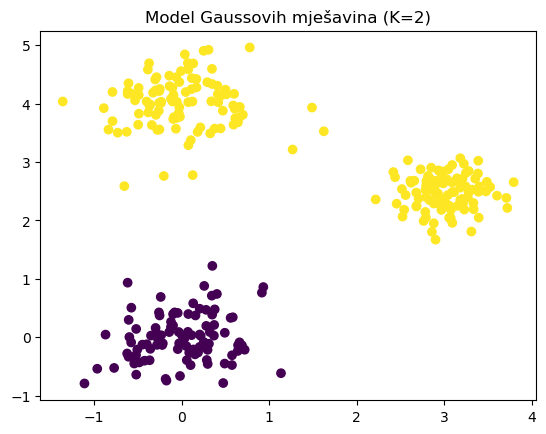

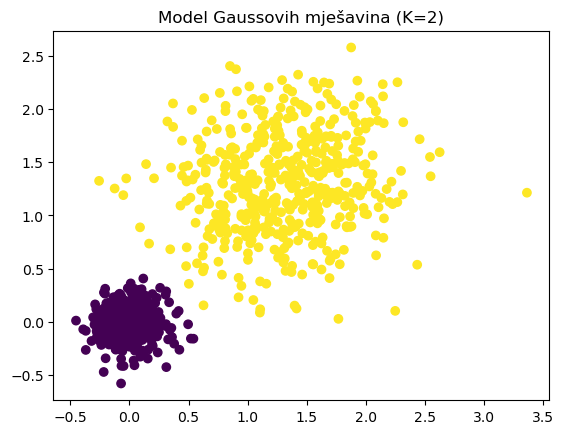

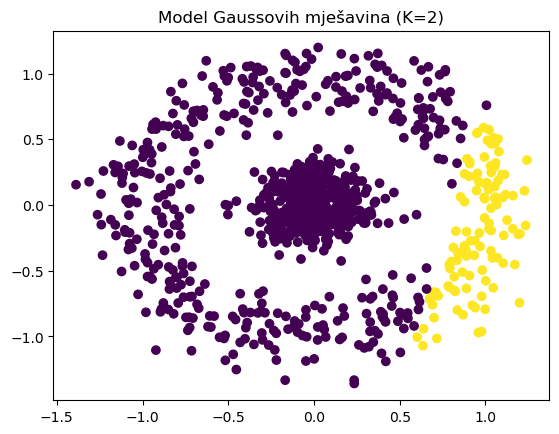

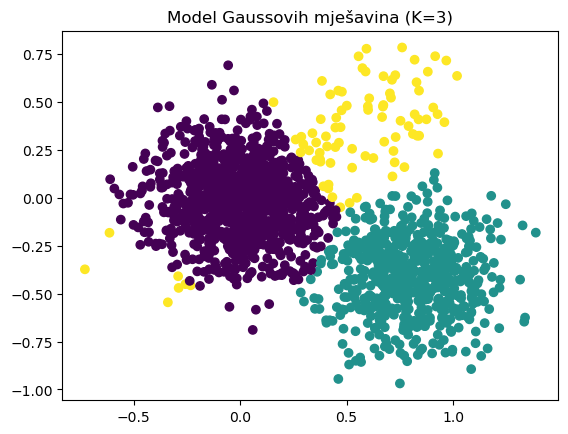

In [26]:
gm_p = GaussianMixture(n_components=2, random_state=0).fit(Xp)
labels_p = gm_p.predict(Xp)
scatter(Xp[:, 0], Xp[:, 1], c=labels_p)
title('Model Gaussovih mješavina (K=2)')
show()

gm_1 = GaussianMixture(n_components=2, random_state=0).fit(X1)
labels_1 = gm_1.predict(X1)
scatter(X1[:, 0], X1[:, 1], c=labels_1)
title('Model Gaussovih mješavina (K=2)')
show()

gm_2 = GaussianMixture(n_components=2, random_state=0).fit(X2)
labels_2 = gm_2.predict(X2)
scatter(X2[:, 0], X2[:, 1], c=labels_2)
title('Model Gaussovih mješavina (K=2)')
show()

gm_3 = GaussianMixture(n_components=3, random_state=0).fit(X3)
labels_3 = gm_3.predict(X3)
scatter(X3[:, 0], X3[:, 1], c=labels_3)
title('Model Gaussovih mješavina (K=3)')
show()


### 8. Vrednovanje grupiranja

Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [27]:
import itertools as it
import math

def rand_index_score(y_gold, y_predict):
    comb_orig = it.combinations(y_gold, 2)
    comb_pred = it.combinations(y_predict, 2)
    
    a = 0; b = 0
    for i1, i2 in zip(comb_orig, comb_pred):
        if(i2[0] == i2[1] and i1[0] == i1[1] and i1[0] == i2[0]): a += 1
    
        if(i2[0] != i2[1] and i1[0] != i1[1]): b += 1
    
    nazivnik = math.comb(len(y_gold), 2)
    
    rand_index = (a+b)/nazivnik
    
    return rand_index

print("Kmeans")
rand_index = rand_index_score(yp, labelsp)
print("Xp - Rand Index:", rand_index)

rand_index = rand_index_score(y1, labels1)
print("X1 - Rand Index:", rand_index)

rand_index = rand_index_score(y2, labels2)
print("X2 - Rand Index:", rand_index)

rand_index = rand_index_score(y3, labels3)
print("X3 - Rand Index:", rand_index)

print("Gaussova mjesavina:")
rand_index = rand_index_score(yp, labels_p)
print("Xp - Rand Index:", rand_index)

rand_index = rand_index_score(y1, labels_1)
print("X1 - Rand Index:", rand_index)

rand_index = rand_index_score(y2, labels_2)
print("X2 - Rand Index:", rand_index)

rand_index = rand_index_score(y3, labels_3)
print("X3 - Rand Index:", rand_index)



Kmeans
Xp - Rand Index: 1.0
X1 - Rand Index: 0.9525525525525526
X2 - Rand Index: 0.29859059059059057
X3 - Rand Index: 0.12130400426337358
Gaussova mjesavina:
Xp - Rand Index: 0.6666666666666666
X1 - Rand Index: 1.0
X2 - Rand Index: 0.26131731731731733
X3 - Rand Index: 0.3475957880809306


**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?   
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?